### GAN 1D

References
- http://blog.naver.com/atelierjpro/220984758512
- https://github.com/hwalsuklee/tensorflow-GAN-1d-gaussian-ex
- http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
- http://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import tensorflow as tf
%matplotlib inline

# Disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
mu = 4
sigma = 0.5
x_real = np.random.normal(mu, sigma, size=10 ** 5)
x_real = np.reshape(x_real, (x_real.shape[0], 1))

In [3]:
class GAN:
    def __init__(self, dim_z, dim_x):
        self.dim_x = dim_x
        self.dim_z = dim_z
        my_init=tf.truncated_normal_initializer(stddev=1.0)
        
        # Placeholders
        self.x = tf.placeholder(tf.float32, [None, self.dim_x])
        self.z = tf.placeholder(tf.float32, [None, self.dim_z])
        self.lr = tf.placeholder(tf.float32)
        
        # Generator
        with tf.variable_scope('G'):
            self.G = tf.layers.dense(self.z, self.dim_x, kernel_initializer=my_init)
        
        # Discriminator
        with tf.variable_scope('D') as scope:
            self.D_real = tf.layers.dense(self.x, 1, activation=tf.sigmoid, kernel_initializer=my_init, name='D')
            scope.reuse_variables()
            self.D_fake = tf.layers.dense(self.G, 1, activation=tf.sigmoid, kernel_initializer=my_init, name='D')
        
        # Losses
        self.loss_G      = tf.reduce_mean(-tf.log(self.D_fake))
        self.loss_D_real = tf.reduce_mean(-tf.log(self.D_real))
        self.loss_D_fake = tf.reduce_mean(-tf.log(1 - self.D_fake))
        self.loss_D      = tf.reduce_mean((self.loss_D_real, self.loss_D_fake))
        
        # Optmizers
        def optimizer(loss, var_list):
            return tf.train.AdamOptimizer(self.lr).minimize(loss, var_list=var_list)
        g_params = [v for v in tf.trainable_variables() if v.name.startswith('G/')]
        d_params = [v for v in tf.trainable_variables() if v.name.startswith('D/')]
        self.train_G = optimizer(self.loss_G, g_params)
        self.train_D = optimizer(self.loss_D, d_params)
        
    def _generate_noise(self, cnt):
        return np.random.uniform(-1., 1., size=[cnt, self.dim_z])
    
    def train(self, sess, x, lr):
        noise = self._generate_noise(x.shape[0])
        sess.run(self.train_D, feed_dict={self.x: x, self.z: noise, self.lr: lr})
        sess.run(self.train_G, feed_dict={           self.z: noise, self.lr: lr})
        
    def loss(self, sess, x):
        noise = self._generate_noise(x.shape[0])
        loss_G = sess.run(self.loss_G, feed_dict={           self.z: noise})
        loss_D = sess.run(self.loss_D, feed_dict={self.x: x, self.z: noise})
        return loss_G, loss_D
    
    def generate_data(self, sess, cnt):
        noise = self._generate_noise(cnt)
        return sess.run(self.G, feed_dict={self.z: noise})

In [4]:
def plot_data(x_real, x_fake, path=None):
    plt.rc('font', size=20)
    
    f, ax = plt.subplots(figsize=(12, 9))
    
    n, bins, patches = plt.hist(x_real, 50, normed=1, facecolor='blue', alpha=0.0)
    y = mlab.normpdf(bins, x_real.mean(), x_real.std())
    l = plt.plot(bins, y, 'b-', linewidth=2.5, label='real data')
    
    n, bins, patches = plt.hist(x_fake, 50, normed=1, facecolor='red', alpha=0.0)
    y = mlab.normpdf(bins, x_fake.mean(), x_fake.std())
    l = plt.plot(bins, y, 'r-', linewidth=2.5, label='generated data')
    
    legend = ax.legend(loc='upper center')
    
    plt.ylabel('Probability')
    plt.title(r'GAN for 1D Data ($\mu = %.1f, \sigma = %.1f$)'%(mu, sigma))
    plt.axis([-6, 6, 0, 1.4])
    plt.grid(True)
    
    if path == None:
        plt.show()
    else:
        plt.savefig(path, bbox_inches='tight')

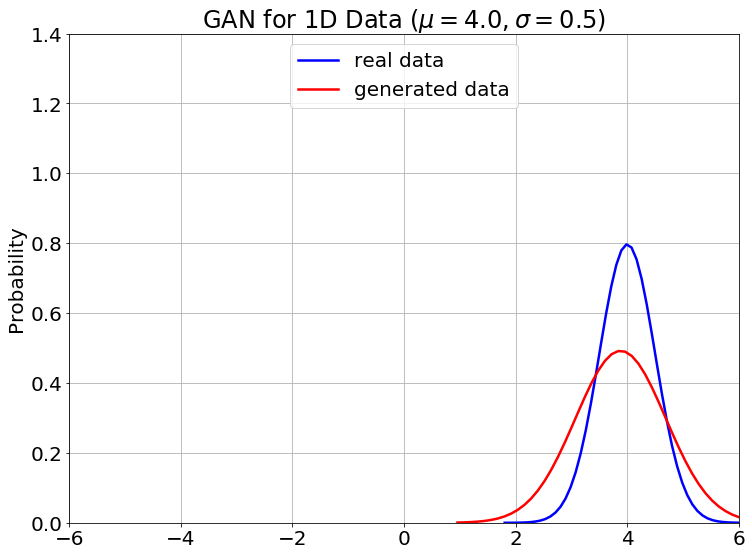

In [5]:
tf.reset_default_graph()

with tf.Session() as sess:
    gan = GAN(dim_z=2*7, dim_x=1)
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    MB_SIZE = 2 ** 0
    NUM_ITER = 50001
    num_img = 1
    
    for iter in xrange(NUM_ITER):
        x_mb = x_real[[random.randint(a=0, b=x_real.shape[0]-1) for _ in range(MB_SIZE)]]
        lr = 0.001 * (1 - float(iter) / NUM_ITER)
        gan.train(sess, x_mb, lr)
        
#         if iter % 100 == 0:
#             x_fake = gan.generate_data(sess, 10 ** 5)
#             plot_data(x_real, x_fake, 'plot_gan1d/%d.png'%num_img)
#             num_img += 1
        if iter == (NUM_ITER-1):
            x_fake = gan.generate_data(sess, 10 ** 5)
            plot_data(x_real, x_fake)